# 2D Transient Navier-Stokes Flow on Tank and Nozzle Geometry 

<b>Problem to Solve</b> 

<b>Goals</b>

<b>Questions</b>
1. run first tests using a coarse mesh (faster computations), a small inlet velocity and a large viscosity; 
2. what causes small initial time step? High inlet velocity (thus small CFL number?). Should the mesh be adapted to the flow? 

<b>Remarks</b>
1. function ferrite_limiter!(): in order to obtain correct higher order convergence for time-dependent Dirichlet conditions, one needs to ensure that all the internal buffers are also correctly set at all times. The limiter helps guarantees this (as the time integrators do also other stuff than just calling your right-hand side). See e.g. [rosenbrock_perform_step.jl](https://github.com/SciML/OrdinaryDiffEq.jl/blob/7a4a5fb6d95f78e973b3d7bb41861058d5b00881/lib/OrdinaryDiffEqRosenbrock/src/rosenbrock_perform_step.jl#L1386-L1388)
2. Rodas5P() failed: results in MethodError: no method matching Rodas5P(; autodiff::Bool, step_limiter!::typeof(ferrite_limiter!))

##  Import Packages

In [1]:
using BlockArrays
using LinearAlgebra
using UnPack
using LinearSolve 
using SparseArrays
using Ferrite
using FerriteGmsh 
using OrdinaryDiffEq
using DifferentialEquations
using Plots 
using WriteVTK

## Section 1: Introduction 

More later.

## Section 2: Definition of Structs 

In [2]:
#..pass data to RHS of time integration 
struct RHSparams
    K::SparseMatrixCSC
    ch::ConstraintHandler
    dh::DofHandler
    cellvalues_v::CellValues
    u::Vector
end

struct FreeDofErrorNorm
    ch::ConstraintHandler
end

## Section 3: Read 2D Mesh from File and Perform Elementary Checks

In [85]:
grid  = togrid("tankAndNozzle.msh")
inlet = getfacetset(grid, "inlet")
wall  = getfacetset(grid, "wall");

Info    : Reading 'tankAndNozzle.msh'...
Info    : 17 entities
Info    : 14713 nodes
Info    : 29424 elements
Info    : Done reading 'tankAndNozzle.msh'


In [86]:
getfacetset(grid,"wall")
getfacetset(grid,"inlet");

## Section 4: Set-up 

In [87]:
function setup_mean_constraint(dh, fvp)
    assembler = Ferrite.COOAssembler()
    # All external boundaries
    set = union(
            getfacetset(dh.grid, "wall"),
            getfacetset(dh.grid, "inlet"),
    )
    # Allocate buffers
    range_p = dof_range(dh, :p)
    element_dofs = zeros(Int, ndofs_per_cell(dh))
    element_dofs_p = view(element_dofs, range_p)
    element_coords = zeros(Vec{2}, 3) # assuming 2D mesh with triangles only 
    Ce = zeros(1, length(range_p)) # Local constraint matrix (only 1 row)
    # Loop over all the boundaries
    for (ci, fi) in set
        Ce .= 0
        getcoordinates!(element_coords, dh.grid, ci)
        Ferrite.reinit!(fvp, element_coords, fi)
        celldofs!(element_dofs, dh, ci)
        for qp in 1:getnquadpoints(fvp)
            dΓ = getdetJdV(fvp, qp)
            for i in 1:getnbasefunctions(fvp)
                Ce[1, i] += shape_value(fvp, qp, i) * dΓ
            end
        end
        # Assemble to row 1
        assemble!(assembler, [1], element_dofs_p, Ce)
    end
    C, _ = finish_assemble(assembler)
    # Create an AffineConstraint from the C-matrix
    _, J, V = findnz(C)
    _, constrained_dof_idx = findmax(abs2, V)
    constrained_dof = J[constrained_dof_idx]
    V ./= V[constrained_dof_idx]
    mean_value_constraint = AffineConstraint(
        constrained_dof,
        Pair{Int,Float64}[J[i] => -V[i] for i in 1:length(J) if J[i] != constrained_dof],
        0.0,
    )

    return mean_value_constraint
end

setup_mean_constraint (generic function with 1 method)

In [88]:
dim = 2 

ip_v = Lagrange{RefTriangle, 2}()^dim
qr = QuadratureRule{RefTriangle}(4)
cellvalues_v = CellValues(qr, ip_v);

ip_p = Lagrange{RefTriangle, 1}()
cellvalues_p = CellValues(qr, ip_p);

ipg = Lagrange{RefTriangle,1}() # linear geometric interpolation
qr_facet = FacetQuadratureRule{RefTriangle}(2)
fvp = FacetValues(qr_facet, ip_p, ipg) # facet values for pressure  

dh = DofHandler(grid)
add!(dh, :v, ip_v)
add!(dh, :p, ip_p)
close!(dh);

ch = ConstraintHandler(dh);

#..Boundary conditions part (1/3): Dirichlet BC for the velocity at the top lid 
∂Ω_inflow = getfacetset(grid, "inlet");
parabolic_inflow_profile(x,t) = Vec((1.5e-2,0.)) 
inflow_bc = Dirichlet(:v, ∂Ω_inflow, parabolic_inflow_profile, [1, 2])
add!(ch, inflow_bc);

#..Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls
nosplip_facet_names = ["wall"];
∂Ω_noslip = union(getfacetset.((grid,), nosplip_facet_names)...);
noslip_bc = Dirichlet(:v, ∂Ω_noslip, (x, t) -> Vec((0.0, 0.0)), [1, 2])
add!(ch, noslip_bc);

# Boundary conditions part (3/3): apply pressure constraint
mean_value_constraint = setup_mean_constraint(dh, fvp)
add!(ch, mean_value_constraint)

close!(ch)
update!(ch, 0.0);

## Section 5: Functions for Mass and Stiffness Matrix Assembly and Other Functions   

In [89]:
function assemble_mass_matrix(cellvalues_v::CellValues, cellvalues_p::CellValues, M::SparseMatrixCSC, dh::DofHandler)
    # Allocate a buffer for the local matrix and some helpers, together with the assembler.
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    Mₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

    # It follows the assembly loop as explained in the basic tutorials.
    mass_assembler = start_assemble(M)
    for cell in CellIterator(dh)
        fill!(Mₑ, 0)
        Ferrite.reinit!(cellvalues_v, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)
            # Remember that we assemble a vector mass term, hence the dot product.
            # There is only one time derivative on the left hand side, so only one mass block is non-zero.
            for i in 1:n_basefuncs_v
                φᵢ = shape_value(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    φⱼ = shape_value(cellvalues_v, q_point, j)
                    Mₑ[BlockIndex((v▄, v▄), (i, j))] += φᵢ ⋅ φⱼ * dΩ
                end
            end
        end
        assemble!(mass_assembler, celldofs(cell), Mₑ)
    end

    return M
end;

function assemble_stokes_matrix(cellvalues_v::CellValues, cellvalues_p::CellValues, ν, K::SparseMatrixCSC, dh::DofHandler)
    # Again, some buffers and helpers
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    Kₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

    # Assembly loop
    stiffness_assembler = start_assemble(K)
    for cell in CellIterator(dh)
        # Don't forget to initialize everything
        fill!(Kₑ, 0)

        Ferrite.reinit!(cellvalues_v, cell)
        Ferrite.reinit!(cellvalues_p, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)

            for i in 1:n_basefuncs_v
                ∇φᵢ = shape_gradient(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    ∇φⱼ = shape_gradient(cellvalues_v, q_point, j)
                    Kₑ[BlockIndex((v▄, v▄), (i, j))] -= ν * ∇φᵢ ⊡ ∇φⱼ * dΩ
                end
            end

            for j in 1:n_basefuncs_p
                ψ = shape_value(cellvalues_p, q_point, j)
                for i in 1:n_basefuncs_v
                    divφ = shape_divergence(cellvalues_v, q_point, i)
                    Kₑ[BlockIndex((v▄, p▄), (i, j))] += (divφ * ψ) * dΩ
                    Kₑ[BlockIndex((p▄, v▄), (j, i))] += (ψ * divφ) * dΩ
                end
            end
        end

        # Assemble `Kₑ` into the Stokes matrix `K`.
        assemble!(stiffness_assembler, celldofs(cell), Kₑ)
    end
    return K
end

function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

function navierstokes_rhs_element!(dvₑ, vₑ, cellvalues_v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    for q_point in 1:getnquadpoints(cellvalues_v)
        dΩ = getdetJdV(cellvalues_v, q_point)
        ∇v = function_gradient(cellvalues_v, q_point, vₑ)
        v = function_value(cellvalues_v, q_point, vₑ)
        for j in 1:n_basefuncs
            φⱼ = shape_value(cellvalues_v, q_point, j)

            dvₑ[j] -= v ⋅ ∇v' ⋅ φⱼ * dΩ
        end
    end
    return
end

function navierstokes!(du, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    # nonlinear contribution
    v_range = dof_range(dh, :v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    vₑ = zeros(n_basefuncs)
    duₑ = zeros(n_basefuncs)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues_v, cell)
        v_celldofs = @view celldofs(cell)[v_range]
        vₑ .= @views u[v_celldofs]
        fill!(duₑ, 0.0)
        navierstokes_rhs_element!(duₑ, vₑ, cellvalues_v)
        assemble!(du, v_celldofs, duₑ)
    end
    return
end;

function navierstokes_jac_element!(Jₑ, vₑ, cellvalues_v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    for q_point in 1:getnquadpoints(cellvalues_v)
        dΩ = getdetJdV(cellvalues_v, q_point)
        ∇v = function_gradient(cellvalues_v, q_point, vₑ)
        v = function_value(cellvalues_v, q_point, vₑ)
        for j in 1:n_basefuncs
            φⱼ = shape_value(cellvalues_v, q_point, j)

            for i in 1:n_basefuncs
                φᵢ = shape_value(cellvalues_v, q_point, i)
                ∇φᵢ = shape_gradient(cellvalues_v, q_point, i)
                Jₑ[j, i] -= (φᵢ ⋅ ∇v' + v ⋅ ∇φᵢ') ⋅ φⱼ * dΩ
            end
        end
    end
    return
end

function navierstokes_jac!(J, u_uc, p, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)

    assembler = start_assemble(J; fillzero = false)

    # Assemble variation of the nonlinear term
    n_basefuncs = getnbasefunctions(cellvalues_v)
    Jₑ = zeros(n_basefuncs, n_basefuncs)
    vₑ = zeros(n_basefuncs)
    v_range = dof_range(dh, :v)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues_v, cell)
        v_celldofs = @view celldofs(cell)[v_range]

        vₑ .= @views u[v_celldofs]
        fill!(Jₑ, 0.0)
        navierstokes_jac_element!(Jₑ, vₑ, cellvalues_v)
        assemble!(assembler, v_celldofs, Jₑ)
    end

    return apply!(J, ch)
end

navierstokes_jac! (generic function with 1 method)

## Section 6: Define Initial Conditions by Solving a Stokes Problem   

In [90]:
K = allocate_matrix(dh,ch);
viscosity = 1e3
K = assemble_stokes_matrix(cellvalues_v, cellvalues_p, viscosity, K, dh);

f = zeros(ndofs(dh))
update!(ch, 0.)
apply!(K, f, ch)
uinit = K \ f;

VTKGridFile("init-tankNozzle-2d", dh) do vtk
    write_solution(vtk, dh, uinit)
    Ferrite.write_constraints(vtk, ch)
end

VTKGridFile for the closed file "init-tankNozzle-2d.vtu".

## Section 7: Perform Naive Time Integration 

In [92]:
T = 6.0
Δt₀ = 0.001
Δt_save = 0.1

M = allocate_matrix(dh);
M = assemble_mass_matrix(cellvalues_v, cellvalues_p, M, dh);

K = allocate_matrix(dh);
viscosity = 1e3
K = assemble_stokes_matrix(cellvalues_v, cellvalues_p, viscosity, K, dh);

jac_sparsity = sparse(K);

apply!(M, ch)

p = RHSparams(K, ch, dh, cellvalues_v, copy(uinit))

rhs = ODEFunction(navierstokes!, mass_matrix = M; jac = navierstokes_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);

(fe_norm::FreeDofErrorNorm)(u::Union{AbstractFloat, Complex}, t) = DiffEqBase.ODE_DEFAULT_NORM(u, t)
(fe_norm::FreeDofErrorNorm)(u::AbstractArray, t) = DiffEqBase.ODE_DEFAULT_NORM(u[fe_norm.ch.free_dofs], t)

problem = ODEProblem(navierstokes!, uinit, (0.0,0.1), p);
problem = ODEProblem(navierstokes!, uinit, (0.0,6), p)
# sol = solve(problem, ImplicitEuler())
# sol = solve(problem, ImplicitEuler(autodiff=false),abstol = 1.0e-5, reltol = 1.0e-5); 

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 6.0)
u0: 130959-element Vector{Float64}:
   -0.0002910265860401851
    0.00023434399961889078
   -0.00028460578364478497
    0.00022001184148180925
   -0.00030224632160488844
    0.0002518784926095669
   -0.0002877680693368763
    0.0002271492554063135
   -0.0002934522601729897
    0.00023680915745394863
   -0.0002967938960754004
    0.00024361978173864266
 -492.16987949437885
    ⋮
    0.00036717241031233974
    0.0009506191975212019
    0.000391812101662507
    0.0009743364741576329
    0.004906373523758225
   -0.0029226781497859477
    0.004527025535260476
    0.0002631628004906809
    0.006279641687239482
   -0.0009857728691402353
    0.006128504752467727
    0.0004899060421041717

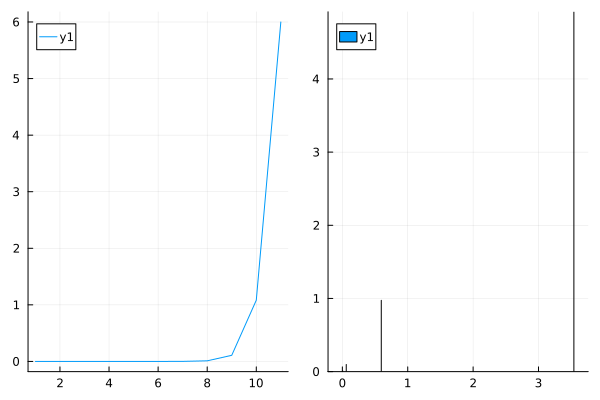

In [66]:
p1 = plot(sol.t)
p2 = bar(sol.t,sol.t[2:end]-sol.t[1:end-1])
plot(p1,p2,layout=(1,2))

## Section 8: Perform Advanced Time Integration
1. timestepper methods include Euler (is explicit or forward Euler), ImplicitEuler
2. what is a sufficiently small time-step for an explicit time integration method? 

In [27]:
?Euler

search: Euler EulerHeun PCEuler ISSEulerHeun LieEuler SplitEuler LambaEulerHeun



Euler - The canonical forward Euler method. Fixed timestep only.


In [93]:
# timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);
# timestepper = AutoTsit5(Rosenbrock23())(autodiff = false, step_limiter! = ferrite_limiter!);
# timestepper = AutoTsit5(autodiff = false, step_limiter! = ferrite_limiter!);
# timestepper = ImplicitEuler(autodiff=false)
timestepper = ImplicitEuler(autodiff=false)

#integrator = init(
#    problem, timestepper; initializealg = NoInit(), dt = Δt₀,
#    adaptive = true, abstol = 1.0e-4, reltol = 1.0e-5,
#    progress = true, progress_steps = 1,
#    verbose = true, internalnorm = FreeDofErrorNorm(ch), d_discontinuities = [1.0]
#);

integrator = init(
    problem, timestepper; dt = Δt₀,
    adaptive = true, abstol = 1.0e-4, reltol = 1.0e-5,
    progress = true, progress_steps = 1,
    verbose = true, internalnorm = FreeDofErrorNorm(ch)
);

## Section 9: Perform Post-Processing 

In [ ]:
pvd = paraview_collection("tankNozzle-2d")
for (step, (u, t)) in enumerate(intervals(integrator))
    display(t)
    VTKGridFile("tankNozzle-2d-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end
vtk_save(pvd);